<a href="https://colab.research.google.com/github/JakeOh/202011_itw_bd21/blob/main/lab_ml/ml14_mnist_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# MNIST Data

In [2]:
X, y = fetch_openml(name='mnist_784', return_X_y=True)

In [3]:
X.shape  # (n_samples, n_features)

(70000, 784)

In [4]:
y.shape  # (n_samples,)

(70000,)

In [9]:
y = y.astype(np.int8)  # str 타입을 int 타입으로 변환
y.dtype

dtype('int8')

In [12]:
X.dtype

dtype('float64')

In [13]:
np.min(X[0])

0.0

In [14]:
np.max(X[0])

255.0

In [15]:
X_scaled = X / 255.0  # 데이터의 값의 범위를 0 ~ 255에서  0 ~ 1 범위로 스케일링

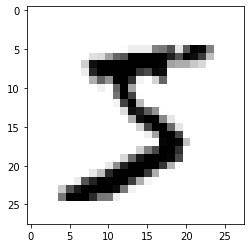

In [16]:
plt.imshow(X_scaled[0].reshape((28, 28)), cmap=plt.cm.binary)
plt.show()

## Train/Test split

In [17]:
num_train = 60_000

In [18]:
X_train, X_test = X[:num_train], X[num_train:]
y_train, y_test = y[:num_train], y[num_train:]

In [19]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [22]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

# PCA(Principal Component Analysis)

## MNIST 데이터의 차원을 2차원으로 축소 후 시각화

In [23]:
pca = PCA(n_components=2)  # PCA 객체 생성

In [24]:
X_train_reduced = pca.fit_transform(X_train)
# fit: 주성분 찾음.
# transform: 주성분 방향으로 투영(projection) -> 차원 축소

In [25]:
X_train_reduced.shape  # (60_000, 2): 샘플 개수, 축소된 차원수

(60000, 2)

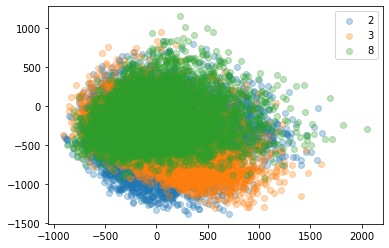

In [33]:
# 훈련 셋에서 숫자 2, 3, 5를 주성분 평면 위에 시각화
for n in (2, 3, 8):
    subset = X_train_reduced[y_train == n]
    plt.scatter(subset[:, 0], subset[:, 1], alpha=0.3, label=n)

plt.legend()
plt.show()

# 95% explained variance ratio

In [34]:
pca = PCA(n_components=0.95, random_state=42)

In [38]:
start_time = time.time()  # fit 시작 시간 기록
pca.fit(X_train)
end_time = time.time()  # fit 종료 시간 기록

In [39]:
end_time - start_time  # 95% 분산을 설명하는 주성분을 찾는데 걸린 시간(초).

13.010912418365479

In [40]:
start_time = time.time()
X_train_reduced = pca.transform(X_train)  # 차원 축소
end_time = time.time()

In [41]:
end_time - start_time  # 차원을 축소하는데 걸린 시간(초)

0.8792998790740967

### 차원 축소 전 훈련 셋 fit 시간 측정, 성능 평가

In [42]:
forest_clf = RandomForestClassifier(n_jobs=-1, random_state=42)  # 모델 생성

In [43]:
start_time = time.time()  # 시작 시간 기록
forest_clf.fit(X_train, y_train)  # 모델 훈련
end_time = time.time()  # 종료 시간 기록

In [45]:
fit_time = end_time - start_time
fit_time

43.10956406593323

In [48]:
# 테스트 셋 평가 시간
start_time = time.time()
acc = forest_clf.score(X_test, y_test)
end_time = time.time()

In [49]:
score_time = end_time - start_time
score_time

0.5371825695037842

In [50]:
acc  # 테스트 셋 정확도

0.9705

### 차원 축소 후 fit 시간, 성능 측정

In [52]:
pca.n_components_

154

In [53]:
start_time = time.time()
forest_clf.fit(X_train_reduced, y_train)  # 차원이 축소된 훈련 셋을 학습.
end_time = time.time()

In [54]:
fit_time_pca = end_time - start_time
fit_time_pca

93.26362872123718

차원 축소된 훈련 셋이 항상 학습 시간을 줄여주는 것은 아님!

In [56]:
# 테스트 셋으로 모델을 평가하려면,
# 차원 축소된 훈련 셋으로 학습됐기 때문에, 테스트 셋도 차원 축소 후에 예측, 평가를 수행해야 함!
X_test_reduce = pca.transform(X_test)  # 테스트 셋 차원 축소

In [57]:
start_time = time.time()
acc_pca = forest_clf.score(X_test_reduce, y_test)
end_time = time.time()

In [59]:
score_time_pca = end_time - start_time
score_time_pca

0.42055320739746094

In [60]:
acc_pca

0.9481

차원 축소가 오히려 성능을 더 안좋게 만듦!

## SGDClassifier 비교

In [61]:
sgd_clf = SGDClassifier(loss='log', n_jobs=-1, random_state=42)

차원 축소 전 훈련 셋 학습, 평가

In [62]:
start_time = time.time()  # 학습 시작 시간 기록
sgd_clf.fit(X_train, y_train)  # 학습
end_time = time.time()  # 학습 종료 시간 기록

In [63]:
fit_time = end_time - start_time
fit_time

127.13540554046631

In [65]:
start_time = time.time()
acc = sgd_clf.score(X_test, y_test)
end_time = time.time()

In [66]:
score_time = end_time - start_time
score_time

0.06506943702697754

In [67]:
acc

0.8784

차원 축소 후 훈련 시간, 성능

In [68]:
sgd_clf = SGDClassifier(loss='log', n_jobs=-1, random_state=42)
start_time = time.time()  # 훈련 시작 시간
sgd_clf.fit(X_train_reduced, y_train)  # 훈련
end_time = time.time()  # 훈련 종료 시간

In [69]:
fit_time_pca = end_time - start_time
fit_time_pca  # 훈련 시간이 1/4 정도로 줄어듦.

33.11617398262024

In [71]:
start_time = time.time()
acc_pca = sgd_clf.score(X_test_reduce, y_test)
end_time = time.time()

In [72]:
score_time_pca = end_time - start_time
score_time_pca

0.017032623291015625

In [73]:
acc_pca

0.8928

PCA를 사용한 차원 축소가 SGDClassifier에서는 훈련 시간도 줄이고, 성능도 좋아짐.